# Analyzing the relation between $Z$, $\alpha$ and "merge/no merge" using information theory

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from itertools import product 

## Introduction
There are many ways to graphically analyze the dependence between $Z$, $\alpha$ and whether or not a merge occurs, but how do we find a quantitative one? It would be very useful to have a more general version of the linear correlation coefficient, a quantity e.g. equal to 0 when our variables are fully independent (not just in a linear way) and equal to 1 when they are fully dependent in a any arbitrary way.              
Fortunately such a quantity can easily be constructed using information theory, as long as we model our problem *probabilistically*.
### Probabilistic view of the merger problem 
If we had perfect knowledge about every property of a binary we would obviously be able to predict deterministically whether or not a merger will occur, but this prediction is of course impossible in practice due to the limited amount of information at our disposal. We quantify the uncertainty consequence of this ignorance using a bayesian definition of probabilities as follows: if $X$ is the boolean variable equal to true/false if a merger occurs/doesn't occur respectively then we may say that $X$ is a *random variable*, meaning that given any binary system we can only assign some probability to the event "this binary will merge" (representing the current state of our knowledge). 
### Shannon entropy
Let's now say that the variable $Y$ represents the pair $(Z, \alpha)$; our problem is then to estimate if knowing the value taken on by $Y$ can reduce the uncertainty associated to the value $X$ itself will take on. This problem can be tackled using information theory as follows.           
Imagine we have a discrete random variable $X$, capable of taking on the values $x_i$'s, and that which $x_i$ will be "chosen" is unknown not necessarily because of an intrinstic stochasticity but due to a lack of "predictive" knowledge. Then we can measure the "surprise" associated to observing $X$ take on any of the $x_i$'s using *Shannon entropy*, defined as follows:
\begin{equation}
  S(X) = -\sum_i p(x_i)\log_2 (p(x_i))
\end{equation}
Why this quantity is able to adequately express "surprise" is easily seen with some examples. Imagine that $X$ is actually not random, and therefore that it will be equal to $x_1$ with probability 1 (for example); this means that every other probability is zero, and by inspecting the definition one immediately finds that $S$ must equal 0. A similar result holds if $X$ is only slightly random; if one probability is very close to 1 and every other to 0 then each term in the sum will be negliglible. See the graph below to understand why this is true.

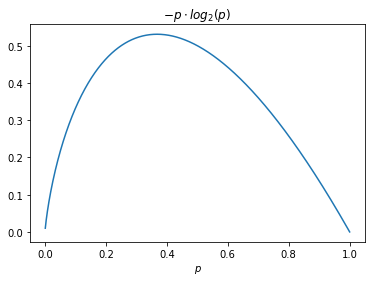

In [3]:
p_plot = np.linspace(0.001, 1, 1000)
plt.plot(p_plot, -p_plot*np.log2(p_plot))
plt.title('$-p \cdot log_2(p)$');
plt.xlabel('$p$');
# p_i close to 0 or 1 yields S_i close to 1

If instead we have a "very" random variable we must therefore have that each $p_i$ is approximately equal to each other, so that one can never have any idea what $x_i$ will turn out. In this case we are in the middle portion of the above graph, which means every term in the sum is significantly different from zero - which in turn means that $S$ becomes large.          
Notice that when one uses the base-2 log entropy is measured in "bits".
### Mutual information
Let's now introduce our second variable $Y$ and ask: "how much can we reduce the surprise associated to $X$ (as measured by the Shannon entropy) if we state in advance that $Y$ is equal to a particular $y_i$?"
The answer to this question turns out to be *mutual information*, defined as 
\begin{equation}
  I(X; Y) = \sum_{y \in \mathcal{Y}} \sum_{x \in \mathcal{X}} p_{X,Y}(x,y) \log_2\left(\frac{p_{X,Y}(x,y)}{p_X(x)p_Y(y)}\right)
\end{equation}
once again measured in bits. Notice that this is just the Kullback-Leibler divergence between the joint distribution $p_{X,Y}(x,y)$ and the product of its two marginals $p_X(x)$, $p_{Y}(y)$; why we want to compare these two quantities is easily seen. Indeed notice that if $X$ and $Y$ are truly independent then $p_{X,Y}(x,y) = p_X(x)p_Y(y)$, which makes $I=0$ - just like the linear correlation coefficient, but in a full general way! If instead the two variables are dependent we will have not only that $p_{X,Y}(x,y) \neq p_X(x)p_Y(y)$, but also that these two distributions will differ more and more. Since the KL divergence gives a way of comparing similarity between distribution in a metric-like fashion we see that $I$ is large when the two distributions are very "distant", and zero when they're identical.              
#### What about scale?
Since $I$ is not measured in familiar units it's not trivial how one would interpret its numerical value; fortunately in our case it's easy to normalize $I$ so that it has no units and lies in the $[0,1]$ interval. Indeed notice that $S_X$ gives us a scale; by comparing $S'_X=S_X-I$ with $S_X$ we can construct a dimensionless ratio between 0 and 1 since in general $0\leq I \leq S_X$ - and this quantity will therefore a similar, but more general interpretation to the linear correlation coefficient!                  
Therefore we need to do two things:
- construct the relevant distributions;
- compute 
\begin{equation}
  \frac{S_X-I}{S_X}
\end{equation}

In [4]:
# first we read the data and construct the values taken on by Y; these simply are all the possible (Z,A) pairs, of which there are 9 in our dataset
df = pd.read_csv("df1_mid.csv")

Z_values, A_values = np.unique(df.Z), np.unique(df.A)
ZA = list(product(Z_values, A_values))
print(ZA)

[(0.0002, 0.1), (0.0002, 1.0), (0.0002, 5.0), (0.002, 0.1), (0.002, 1.0), (0.002, 5.0), (0.02, 0.1), (0.02, 1.0), (0.02, 5.0)]


In [5]:
# We now want to create our joint distribution as a 2x9 matrix; each row will represent one possible value of X, an so on for the columns and Y.
# These two rows can be computed by counting how many rows havve that value of X and Y wrt the total.

p = np.zeros(len(ZA)) # probabilities vector for mergers
p2 = np.zeros(len(ZA)) # ...for no-mergers

df_merge = df[df.BWorldtime + df.Merge_time_midpoint < 14e3]
print("n. of mergers:", len(df_merge))
print(f"fraction of mergers wrt total: {len(df_merge)/len(df):%}")

df_no_merge = df[df.BWorldtime + df.Merge_time_midpoint > 14e3]

for i, tup in enumerate(product(Z_values, A_values)) :
    Z, A = tup
    p[i] = len(df_merge[(df_merge.Z == Z) & (df_merge.A == A)])/len(df) 
    p2[i] = len(df_no_merge[(df_no_merge.Z == Z) & (df_no_merge.A == A)])/len(df)
    print(f"merge prob. for (Z,A) = {tup}: {p[i]}") 

print("\n")
print("prob. vec. for mergers:", p, '\n')
print("prob. vec. for no-mergers:", p2)

n. of mergers: 42442
fraction of mergers wrt total: 18.449033%
merge prob. for (Z,A) = (0.0002, 0.1): 0.009337100630297761
merge prob. for (Z,A) = (0.0002, 1.0): 0.030454249076287764
merge prob. for (Z,A) = (0.0002, 5.0): 0.06350358617691806
merge prob. for (Z,A) = (0.002, 0.1): 0.006350793305803086
merge prob. for (Z,A) = (0.002, 1.0): 0.030901977830906324
merge prob. for (Z,A) = (0.002, 5.0): 0.03923929580525973
merge prob. for (Z,A) = (0.02, 0.1): 0.002329928276461639
merge prob. for (Z,A) = (0.02, 1.0): 0.001469245816126929
merge prob. for (Z,A) = (0.02, 5.0): 0.0009041512714627255


prob. vec. for mergers: [0.0093371  0.03045425 0.06350359 0.00635079 0.03090198 0.0392393
 0.00232993 0.00146925 0.00090415] 

prob. vec. for no-mergers: [0.08447294 0.11858292 0.16730276 0.08061291 0.09047164 0.11656596
 0.05324929 0.0522669  0.05198435]


In [6]:
# now that we have the two rows separately we can vstack them to obtain the needed matrix
joint_pmf = np.vstack((p, p2))
print(joint_pmf)
print('joint pdf normalization:', joint_pmf.sum()) # sanity check

[[0.0093371  0.03045425 0.06350359 0.00635079 0.03090198 0.0392393
  0.00232993 0.00146925 0.00090415]
 [0.08447294 0.11858292 0.16730276 0.08061291 0.09047164 0.11656596
  0.05324929 0.0522669  0.05198435]]
joint pdf normalization: 1.0


In [7]:
# remember that X = merge, Y = (Z,A)
# since we are working with discrete distributions to obtain the two marginals it suffices to sum along the rows/columns of our matrix
pdf_X = joint_pmf.sum(axis = 1)
pdf_Y = joint_pmf.sum(axis = 0)
print(pdf_X.shape[0], pdf_Y.shape[0])
print("marginal X:", pdf_X)
print("marginal Y:", pdf_Y)

2 9
marginal X: [0.18449033 0.81550967]
marginal Y: [0.09381004 0.14903717 0.23080635 0.0869637  0.12137361 0.15580526
 0.05557922 0.05373614 0.0528885 ]


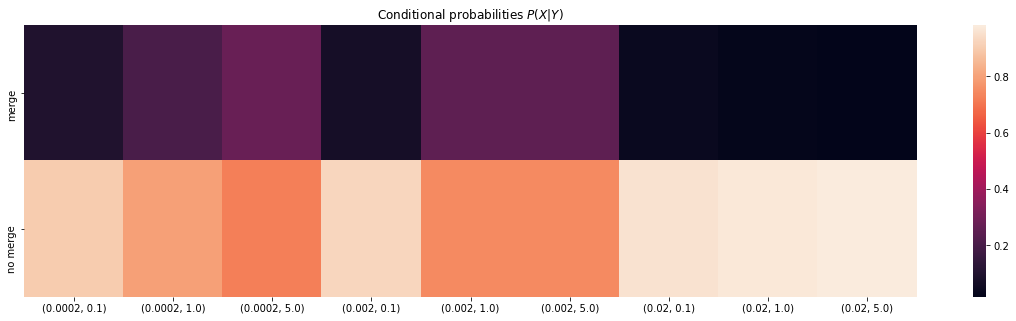

In [8]:
# before proceeding note that of course there are other uses to these distributions, such as computing the conditionals P(X|Y) i.e. the probabilities that a merger will occur with some specified values for Z and A
fig, ax = plt.subplots(figsize = (20, 5))
sns.heatmap(joint_pmf/pdf_Y, ax = ax)
ax.set_title('Conditional probabilities $P(X|Y)$')
ax.set_yticklabels(['merge', 'no merge'])
ax.set_xticklabels(ZA);

In [9]:
# Now we proceed with I's computation

# notice that the values taken on by the p(x)p(y) term in the determinator in Y can be computed all at once, since the associated distribution p(X)p(Y) is the outer product
# of the two marginals computed above
prod_pdf = np.outer(pdf_X, pdf_Y)
I = (np.log2(joint_pmf/prod_pdf)*joint_pmf).sum() # I's definition
print("mutual information between X and Y:", I)

mutual information between X and Y: 0.05190732771384882


In [10]:
ent_X = -(np.log2(pdf_X)*pdf_X).sum() # we compute X's original entropy to compare it with I
print("entropy of X:", ent_X)

entropy of X: 0.6898022997106766


In [11]:
ent_Y = -(np.log2(pdf_Y)*pdf_Y).sum()
print("entropy of Y:", ent_Y)

entropy of Y: 2.9940494771650528


In [15]:
# S_X' = S_X - I, because by specifying that (Z,A) took on a particular value can reduce the indetermination over X given that X and Y are correlated in some way. For example we know that some Z,A values are better than others at leading to a merger, hence if we know that Y equals to one of these lucky pairs then we can be more certain that X may be true - thus reducing "surprise" upon seeing the result.

print(f"Of the {ent_X:.3f} bits of information associated to the indetermination over X approx. {I:.3f} are shared with the {ent_Y:.3f} bits of Y's entropy.")
print(f"This means that by specifying (Z,A)'s value we reduce the indetermination over X = merge/no merge by approx. {I/ent_X:.3%} wrt its original entropy value")
print(f"To put this in another way: S_X'/S_X = {(1 - I/ent_X):.3%}")

Of the 0.690 bits of information associated to the indetermination over X approx. 0.052 are shared with the 2.994 bits of Y's entropy.
This means that by specifying (Z,A)'s value we reduce the indetermination over X = merge/no merge by approx. 7.525% wrt its original entropy value
To put this in another way: S_X'/S_X = 92.475%


## Beyond a frequentist computation: the bayesian approach
There is an interesting way to improve the above pipeline, which is to replace a frequentist computation of probabilities with a bayesian one. This is a desirable thing to do because by computing probabilities as n. of successess/n. total we are almost guaranteeing that if we repeat our "experiment" we will observe different values; this wouldn't be an issue if we could estimate some errors/intervals for e.g. the conditionals, but this is never trivial, general or intuitive enough in a frequentist setting - or at least not as much as it is in a bayesian one, where the posterior alone contains everything we could possibly need.                      
To setup a bayesian approach we first need to observe that if we think of $X$ and $Y$ as variables generated by an unknown likelihood then it's clear that with our limited $(Z,\alpha)$ resolution this likelihood is a *multinomial*, where every "slot" corresponds to one "experimental" bin. This multinomial's parameters are unknown; before we obtained a single estimate for them using the frequentist MLE estimator (cfr [here](https://math.stackexchange.com/a/421838)), but now we learn this likelihood using the so called *Dirichlet process*. With this we mean that since the Dirichlet distribution is the multinomial's conjugate prior (similarly to binomial/beta, which are respectively special cases of multinomial/Dirichlet) one can easily obtain the posterior over the $p_i$'s as a Dirichlet distribution, computed using some simple update rules starting e.g. from a uniform prior (i.e. a Dirichlet with all ones); in particular one finds that if the prior is a Dirichlet with $\alpha_i$ as parameters then the posterior will have $\alpha_i + n_i$ as parameters, where $n_i$ is the number of occurrences of $i$ (cfr [here](https://en.wikipedia.org/wiki/Conjugate_prior)).         

In [13]:
# in our case given a uniform prior (i.e. Dirichlet with all ones) the posterior is a Dirichlet with the following parameters
alpha = (p*len(df)).astype(int) + 1
print(alpha)

[ 2149  7007 14610  1462  7110  9028   537   339   209]


Each point in the 9D space where the Dirichlet distribution is defined represents a 9-tuple of values to be used as parameters for the multinomial likelihood; a simple way to use this information would be to for example construct a region around the mode such that its integral equals 95% prob. (cfr `scipy.integrate.nquad`), then use this region to assign error bars to each $p_i$ - themselves set equal to the coordinates of the posterior's maximum. This is already very interesting as it gives us a mean of trusting more our results (since in a sense they depend less on the dataset), but can also be used in relation to our mutual information problem. Indeed if we have a 9D range where most plausible values lie we can compute our "nonlinear correlation coefficient" for many values and see the resulting distribution; in particular we could see what's the "score" associated to the most likely candidates, etc.

The only nontrivial part about the outlined plan is how to "move" and integrate in 9D, which is quite hard to imagine, in a way which is general and scales to an arbitrary $n$ (as this would be needed if we decided to enrich our dataset with more $Z$ and/or $\alpha$ values). Since we are satisfied with the results already at hand we chose not to pursue this idea any further, rather leaving it as a suggestion for future studies.